# NN for prediction in lorentz equation
The script here is partially derived from "lorenz3.ipynb"

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy import integrate
import tensorflow as tf
from tensorflow import keras as K
import os

cwd = os.getcwd()
savefig = os.path.join(cwd, 'Images')

In [2]:
# Parameters of the problem
dt = 0.01
T = 5 # 5 seconds this time
t = np.arange(0, T+dt, dt)
t_len = len(t)
beta = 8/3
sigma = 10
rhos = [10, 28, 35] # This time rho is a list
n_points = 100 # Number of starting points (initial conditions for lorentz equations)

print(f"There are {t.shape[0]} time snapshots.")

# preallocation of the arrays for the neural network
tot_points = len(rhos)*n_points*(len(t)-1)
nn_input = np.zeros((tot_points,4))
nn_output = np.zeros((tot_points,3))

There are 501 time snapshots.


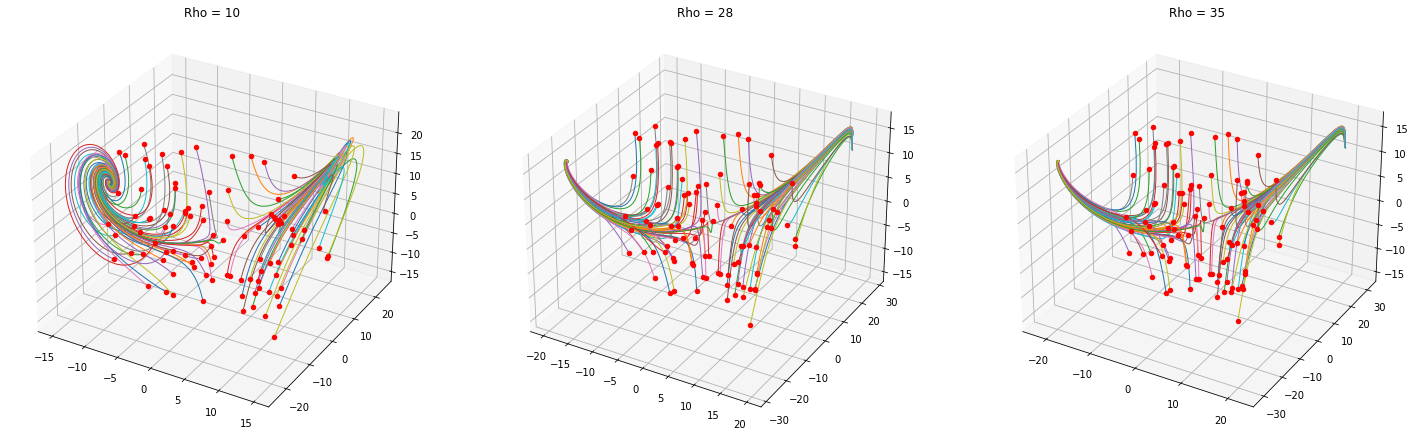

In [6]:
# Let's generate a figure to see how the lorentz equation appears with different 
# starting points and for the 3 rhos:

def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=3, rho=15):
    """This function takes the derivative of a point wrt time according the 
    Lorentz equations."""

    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(123)
x0 = -15 + 30 * np.random.random((n_points, 3))

plt.figure(figsize=(25,8), facecolor="white")
for idx, rho in enumerate(rhos):
    

    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t, (beta, rho)) 
    for x0_j in x0]) # Extra argument in a tuple!   
    
    # Plot!
    ax = plt.subplot(1,3,idx+1, projection='3d')
    plt.title(f"Rho = {rho}")

    
    for j in range(n_points):

        # Insert the predictions in the input/output arrays for the NN
        in_idx = (idx)*n_points*(len(t)-1) + j*(t_len-1)
        end_idx = (idx)*n_points*(len(t)-1) + (j+1)*(t_len-1)
        nn_input[in_idx:end_idx,:-1] = x_t[j,:-1,:] # Filling with the datapoints
        nn_input[in_idx:end_idx,-1] = rho # filling the rhos
        nn_output[in_idx:end_idx,:] = x_t[j,1:,:]
        x, y, z = x_t[j,:,:].T # .T trasposes the NDarray
        ax.plot(x, y, z,linewidth=1)
        ax.scatter(x0[j,0], x0[j,1], x0[j,2], color='r')

plt.savefig(os.path.join(savefig, 'lorentz_original'))

In [4]:
# Training of the neural network.


# Model definition
# x_in = K.Input(shape=(4,))
# y = K.layers.Dense(10, activation="relu")(x_in)
# y = K.layers.Dense(10, activation="relu")(y)
# y = K.layers.Dense(10, activation="relu")(y)
# y = K.layers.Dense(3, activation="linear")(y)
# model = K.Model(x_in, y)

# # Model .compile
# model.compile(
#     optimizer="adam",
#     loss="mean_absolute_error",
#     metrics=None,
# )

# # fitting
# train_history = model.fit(
#     x = nn_input,
#     y = nn_output,
#     shuffle=True,
#     epochs=500,
#     verbose=2,
#     use_multiprocessing=True,
#     workers=8,
#     batch_size = 128
# )

# model.save(os.path.join(cwd,"LOR_model1"))



# Prevision and comparison
Now we must use the network to make prevision iteratively. We must now generate new random points (or use some of the previous ones) and then:
- Create a list of new rhos
- for every rho apply both the differential equations and the neural network
- Make the two plots
- Finally define a function to quantify the distance of the two


2/2 - 0s - 47ms/epoch - 23ms/step
2/2 - 0s - 16ms/epoch - 8ms/step
2/2 - 0s - 17ms/epoch - 9ms/step
2/2 - 0s - 18ms/epoch - 9ms/step
2/2 - 0s - 21ms/epoch - 11ms/step
2/2 - 0s - 15ms/epoch - 7ms/step
2/2 - 0s - 17ms/epoch - 8ms/step
2/2 - 0s - 14ms/epoch - 7ms/step
2/2 - 0s - 17ms/epoch - 9ms/step
2/2 - 0s - 16ms/epoch - 8ms/step
2/2 - 0s - 16ms/epoch - 8ms/step
2/2 - 0s - 16ms/epoch - 8ms/step
2/2 - 0s - 17ms/epoch - 9ms/step
2/2 - 0s - 17ms/epoch - 8ms/step
2/2 - 0s - 17ms/epoch - 8ms/step
2/2 - 0s - 16ms/epoch - 8ms/step
2/2 - 0s - 17ms/epoch - 9ms/step
2/2 - 0s - 16ms/epoch - 8ms/step
2/2 - 0s - 18ms/epoch - 9ms/step
2/2 - 0s - 15ms/epoch - 8ms/step
2/2 - 0s - 19ms/epoch - 10ms/step
2/2 - 0s - 16ms/epoch - 8ms/step
2/2 - 0s - 15ms/epoch - 7ms/step
2/2 - 0s - 18ms/epoch - 9ms/step
2/2 - 0s - 18ms/epoch - 9ms/step
2/2 - 0s - 16ms/epoch - 8ms/step
2/2 - 0s - 17ms/epoch - 9ms/step
2/2 - 0s - 19ms/epoch - 9ms/step
2/2 - 0s - 13ms/epoch - 7ms/step
2/2 - 0s - 18ms/epoch - 9ms/step
2/2 - 0

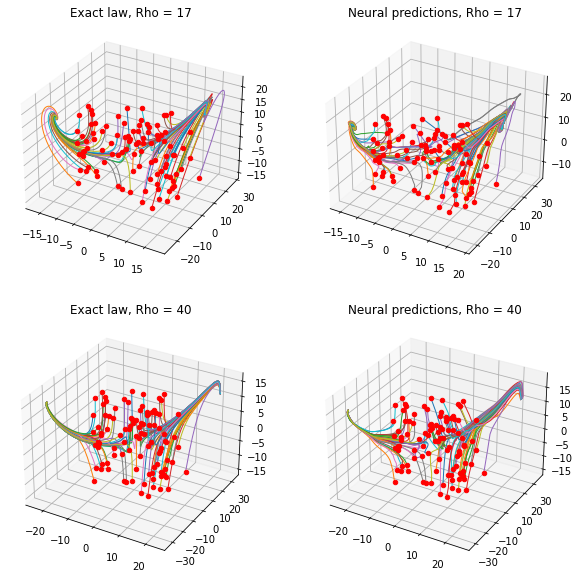

In [9]:
# Loading TF model
NN = K.models.load_model(os.path.join(cwd,"LOR_model1"))

# We generate a new set of initial conditions
np.random.seed(99)
x0 = -15 + 30 * np.random.random((n_points, 3))

# The new rhos
rhos = [17, 40]

plt.figure(figsize=(10,10), facecolor="white")
k = 1
losses = {}
for rho in rhos:

    # Points derived from the Lorentz law:
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t, (beta, rho)) 
    for x0_j in x0]) 

    # Plot of the datapoints from the exact equations
    ax = plt.subplot(2,2,k, projection='3d')
    plt.title(f"Exact law, Rho = {rho}")

    for j in range(n_points):
        x, y, z = x_t[j,:,:].T # .T trasposes the NDarray
        ax.plot(x, y, z,linewidth=1)
        ax.scatter(x0[j,0], x0[j,1], x0[j,2], color='r')

    # Preallocation
    X_pred = np.zeros((n_points, t_len, 4))
    X_pred[:,0,:-1] = x0 # saving the initial conditions in the first row
    X_pred[:,:,-1] = rho # Rho is an input of the NN


    # Plot of the previsions with the neural network
    ax = plt.subplot(2,2,k+1, projection='3d')
    plt.title(f"Neural predictions, Rho = {rho}")

    for step in range(t_len-1):

        # Prediciton of the first timestep (All initial conditions in one)
        pred = NN.predict(X_pred[:, step,:],verbose=2,batch_size=64, workers=2)

        # Saving the predicitons 
        X_pred[:, step+1,:-1] = pred

    for j in range(n_points):

        x, y, z = X_pred[j,:,:-1].T # .T trasposes the NDarray
        ax.plot(x, y, z,linewidth=1)
        ax.scatter(x0[j,0], x0[j,1], x0[j,2], color='r')

        # Let's compute now the difference between the exact curve and the one 
        # Obtained by the neural network previsions:
    
    # Cumulative sum
    cum_error = 0
    for j in range(n_points):
        for i in range(t_len):

            # Euclidean distance between two twin-points (exact VS NN, same timestep)
            dist = np.linalg.norm(x_t[j, i, -1] - X_pred[j, i, -1])
            cum_error = cum_error + dist

    losses[f"rho{rho}"] = cum_error
    k += 2

plt.savefig(os.path.join(savefig, 'lorentz_NN'))

In [11]:
plt.savefig(os.path.join(savefig, 'lorentz_NN'))

if losses[f"rho{rhos[0]}"] > losses[f"rho{rhos[0]}"]:
    print(f"Rho = {rhos[0]} has the greater loss.")
else:
    print(f"Rho = {rhos[1]} has the greater loss.")

print(f"Oderd of magnitude of tho = {rhos[0]}: {np.log10(losses['rho17'])}")
print(f"Oderd of magnitude of tho = {rhos[1]}: {np.log10(losses['rho40'])}")

Rho = 40 has the greater loss.
Oderd of magnitude of tho = 17: 5.2621340414874505
Oderd of magnitude of tho = 40: 6.12874099917022


<Figure size 432x288 with 0 Axes>